In [37]:
import sys
import os
import cv2
from PIL import Image
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [2]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
num_classes = 10
nb_epochs = 10
img_sz = (224, 224)

# data paths
data_path = '../../../data/asl_digits/'

# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    rescale=1./255,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    validation_split=0.2)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
# valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=img_sz,
        color_mode='rgb',
        batch_size=10,
        class_mode='categorical',
        subset='training')
test_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=img_sz,
        color_mode='rgb',
        batch_size=10,
        class_mode='categorical',
        subset='validation')
# validation_generator = valid_datagen.flow_from_directory(
#         validation_path,
#         target_size=img_sz,
#         color_mode='rgb',
#         batch_size=32,
#         class_mode='categorical')

Found 1654 images belonging to 10 classes.
Found 409 images belonging to 10 classes.


In [5]:
next(train_generator)[0][0].shape

(224, 224, 3)

In [6]:
base_model = MobileNet() #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.layers[-6].output
predictions = Dense(10, activation='softmax')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# for layer in model.layers:
#     layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:-23]:
    layer.trainable=False

In [9]:
# model.add(resnet_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(.25))
# model.add(BatchNormalization())
# model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizers.Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
EarlyStop = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                           min_delta=0,
                                           patience=1,
                                           verbose=0,
                                           mode="auto",
                                           baseline=None,
                                           restore_best_weights=False)
TensorBoard = keras.callbacks.TensorBoard(log_dir='./tensorboard_logs')

callbacks = [EarlyStop, TensorBoard]
t=time.time()
historytemp = model.fit(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=15,
                        validation_data=test_generator,
                        callbacks=callbacks)
print('Training time: %s' % (t - time.time()))

Epoch 1/15
166/166 [==============================] - 54s 323ms/step - loss: 0.4586 - accuracy: 0.8791 - val_loss: 0.7014 - val_accuracy: 0.7579
Epoch 2/15
166/166 [==============================] - 63s 377ms/step - loss: 0.1009 - accuracy: 0.9849 - val_loss: 0.3506 - val_accuracy: 0.9046
Epoch 3/15
166/166 [==============================] - 77s 462ms/step - loss: 0.0446 - accuracy: 0.9946 - val_loss: 0.3236 - val_accuracy: 0.9046
Training time: -194.05204510688782


In [18]:
next(test_generator)[0][0].shape

(224, 224, 3)

In [71]:
im = Image.open('../../../data/asl_digits/0/IMG_1118.JPG').resize((224,224))
np.expand_dims(im,axis=0).shape

(1, 224, 224, 3)

### Predictions

In [78]:
test_labels = test_generator.labels

In [79]:
len(test_labels)

409

In [81]:
predictions = model.predict_generator(test_generator, verbose=0)

In [82]:
len(predictions)

409

In [86]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [87]:
test_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [93]:
cm

array([[ 5,  2,  7,  3,  1,  3,  9,  2,  4,  5],
       [ 2,  7,  3,  1,  3,  7,  4,  6,  2,  6],
       [ 4, 11,  4,  2,  4,  4,  3,  0,  4,  5],
       [ 6,  1,  8,  5,  1,  6,  3,  5,  5,  1],
       [ 5,  5,  4,  6,  3,  2,  6,  4,  1,  5],
       [ 4,  3,  4,  5,  5,  5,  3,  4,  3,  5],
       [ 4,  3,  4,  5,  2,  3,  4,  5,  4,  7],
       [ 4,  5,  5,  4,  3,  6,  5,  1,  2,  6],
       [ 4,  2,  7,  2,  3,  4,  5,  3,  5,  6],
       [ 4,  7,  1,  7,  2,  4,  6,  3,  1,  5]])

/Users/sam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


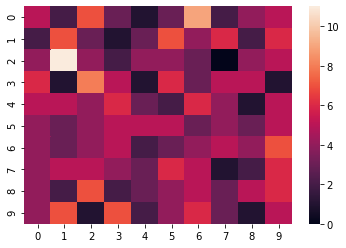

In [92]:
import seaborn as sns

cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
sns.heatmap(cm)

In [70]:
model.save('../models/digits_model_1.h5')